In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Pauli, pauli_basis, SuperOp, PTM, Operator
from qiskit.circuit.library import CXGate, CZGate, HGate, SGate, SdgGate
from random import choice, choices
from itertools import product, permutations, cycle
from scipy.optimize import curve_fit, nnls
from matplotlib import pyplot as plt
import numpy as np
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigoV2
from qiskit.providers.aer import Aer
from typing import List, Tuple, Dict
from qiskit.providers.backend import Backend, BackendV1, BackendV2
from sympy import singularities
from collections import namedtuple
import scipy as sc

plt.rcParams["figure.figsize"] = (6.4,4.0)

In [3]:
QUBIT = int
DOUBLE_GATE = 2
SINGLE_GATE = 1
NUM_BASES = 9

class LearningProcedure:
    def __init__(self, layer, backend):
        self.qubits = [q.index for q in layer.qubits]

        self.layer = QuantumCircuit(layer.num_qubits)
        for gate in layer:
            if gate.operation.num_qubits == 2:
                self.layer.append(gate)

        self.backend = backend
        self.n = layer.num_qubits

        self.bases = self.pauli_bases(backend.coupling_map.reduce(self.qubits))
        self.model_paulis = self.model_terms(backend.coupling_map.reduce(self.qubits))


    def pauli_bases(self, connectivity):

        n = self.n
        bases = [['I']*(np.max(self.qubits)+1) for i in range(NUM_BASES)]
        remaining = set(self.qubits)

        while remaining:
            vertex = remaining.pop()
            #copied from Fig. S3 in van den Berg
            orderings = {"XXXYYYZZZ":"XYZXYZXYZ",
                                "XXXYYZZZY":"XYZXYZXYZ",
                                "XXYYYZZZX":"XYZXYZXYZ",
                                "XXZYYZXYZ":"XYZXZYZYX",
                                "XYZXYZXYZ":"XYZZXYYZX"}

            children = set(connectivity.neighbors(vertex))
            predecessors = children.difference(remaining)

            match len(predecessors):
                #trivial if no predecessors
                case 0:
                    cycp = cycle("XYZ")
                    for i,_ in enumerate(bases):
                        bases[i][vertex] = next(cycp)
                #Choose p1:"XXXYYYZZZ" and p2:"XYZXYZXYZ" if one predecessor
                case 1:
                    pred, = predecessors
                    #store permutation of indices so that predecessor has X,X,X,Y,Y,Y,Z,Z,Z
                    bases = list(zip(*sorted(zip([p[pred] for p in bases], bases))))[1]
                    cycp = cycle("XYZ")
                    for i,_ in enumerate(bases):
                        bases[i][vertex] = next(cycp)
                case 2:
                    pred0,pred1 = predecessors
                    bases = list(zip(*sorted(zip([p[pred0] for p in bases], bases))))[1]
                    #list out string with permuted values of predecessor 2
                    substr = [p[pred0] for p in bases]
                    #match predecessor two with a permutation of example_orderings
                    reordering = ""
                    for perm in permutations("XYZ"):
                        p_substr = "".join(["XYZ"[perm.index(p)] for p in p_substr])
                        if p_substr in orderings:
                            current = orderings[p_substr] 
                            for i,p in enumerate(current):
                                bases[i][vertex] = p
                            break
                case _: #processor needs to have connectivity so that there are <= 2 predecessors
                    raise Exception("Three or more predecessors encountered")

        print("Pauli bases were chosen:",["".join(string[::-1]) for string in bases])

        return [Pauli("".join(string[::-1])) for string in bases]

    def model_terms(self, connectivity):
        n = self.n
        model_terms = set()
        identity = Pauli("I"*(np.max(self.qubits)+1))    

        #get all single-weight paulis
        for i in self.qubits:
            for op in pauli_basis(1, pauli_list = True):
                pauli = identity.copy()
                pauli[i] = op
                model_terms.add(pauli)
                
        #get all weight-two paulis on with suport on nieghboring qubits
        for q1, q2 in connectivity.graph.edge_list():
            for p1, p2 in pauli_basis(2, pauli_list = True):
                pauli = identity.copy()
                pauli[q1] = p1
                pauli[q2] = p2
                model_terms.add(pauli)

        model_terms.remove(identity)
        print("The terms included in the model are the following:", [p.to_label() for p in model_terms])
        return list(model_terms)
    
    def instance(
        self, 
        prep_basis : Pauli, 
        meas_basis : Pauli, 
        noise_repetitions : int, 
        transpiled=True
        ):

        n = np.max(self.qubits)+1
        backend = self.backend
        qubits = self.qubits
        circ = QuantumCircuit(n,self.n) #storing the final circuit

        def nophase(pauli):
            return Pauli((pauli.z, pauli.x))

        #get preparation ops from desired basis 
        def prep(basis, qubit, qc):
            if basis.equiv(Pauli("X")):
                qc.h(qubit) 
            elif basis.equiv(Pauli("Y")):
                qc.h(qubit)
                qc.s(qubit)

        #apply operators to a quantum circuit to measure in desired pauli basis
        def meas(basis, qubit, qc):
            if basis.equiv(Pauli("X")):
                qc.h(qubit)
            elif basis.equiv(Pauli("Y")):
                qc.sdg(qubit)
                qc.h(qubit)

        pauli_frame = Pauli("I"*n)
        qc = QuantumCircuit()
        #apply the prep and twirling operators to the circuit
        for qubit,b in enumerate(prep_basis):
            prep(b,qubit,circ)

        #apply repetitions of noise, including basis-change gates when needed
        for i in range(noise_repetitions):

            twirl = choice(pauli_basis(n, pauli_list = True))
            for i,p in enumerate(twirl):
                circ.append(p,[i])

            circ = circ.compose(self.layer)

            pauli_frame = pauli_frame.compose(twirl)
            pauli_frame = pauli_frame.evolve(self.layer)
            
            circ.barrier()

        #choose sstring of bit flips for readout twirling
        rostring = choices([0,1], k=n)

        for q,(p,b,r) in enumerate(zip(pauli_frame, meas_basis, rostring)):
            circ.append(p, [q])
            meas(b, q, circ)
            if r:
                circ.x(q)

        circ.barrier()

        if transpiled:
            circ = transpile(circ, backend, optimization_level = 1)
            for i,q in enumerate(qubits):
                circ.measure(q,i)
        else:
            for i in range(n):
                circ.measure(i,i)

        return circ, {
            "prep_basis":prep_basis,
                "meas_basis":meas_basis, 
                "depth":noise_repetitions, 
                "rostring":rostring[::-1],
                }

    def procedure(
        self,
        depths,
        samples,
        single_samples = None,
        transpiled = True
    ):

        if isinstance(samples, int):
            samples = [samples]*len(depths)
        if not single_samples:
            single_samples = samples[0]

        self.depths = depths
        self.single_samples = single_samples

        def weight(pauli):
            return len([p for p in pauli if not p==Pauli("I")])

        def nophase(pauli):
            return Pauli((pauli.z, pauli.x))
            
        pairs = [(p, nophase(p.evolve(self.layer))) for p in self.model_paulis]

        single_measurements = [(p1,p2) for (p1,p2) in pairs if p1 != p2 and weight(p1) == 1 and weight(p2) == 2]
        single_measurements += list(set([frozenset([p1,p2]) for p1,p2 in pairs if p1 != p2 and weight(p1) == weight(p2) == 2]))
        single_measurements = [list(s) for s in single_measurements]

        print("The following pairs require single measurements:", single_measurements)

        circuits = []
        metadatas = []
        bases = self.bases
        total = len(bases)*sum(samples)+len(single_measurements)*single_samples

        j=0
        for basis, (d,s) in product(bases, zip(depths,samples)):

            for i in range(s):
                circ, data = self.instance(
                    basis, 
                    basis, 
                    d, 
                    transpiled
                    )

                j+=1
                print(j,"/",total, end='\r')
                circuits.append(circ)
                metadatas.append(dict(**data, type = "double"))
        
        for (pauli, pair), s in product(single_measurements, range(single_samples)):

            circ, data = self.instance(
                pair,
                pauli,
                1,
                transpiled
            )
            j+=1
            print(j,"/",total, end='\r')
            circuits.append(circ)
            metadatas.append({"type":"single", **data})

        print("Generated", len(circuits), "circuits")

        return circuits, metadatas

In [18]:
class ProcedureAnalysis:
    def __init__(self, layer, qubits, depths, single_samples, model_terms):
        self.n = len(qubits) 
        self.qubits = qubits 
        self.layer = layer
        
        self.depths = depths
        self.single_samples = single_samples

        self.model_terms = model_terms

    @classmethod
    def fromExperiment(cls, experiment):
        return cls(
            experiment.layer,
            experiment.qubits,
            experiment.depths,
            experiment.single_samples,
            experiment.model_paulis
        )

    def get_expectation(self, measurement, **metadata):
        total = 0
        counts = metadata['counts']
        pauli_weight = tuple(reversed([{Pauli("I"):0}.get(measurement[q],1) for q in self.qubits]))
        rostring = metadata['rostring']
        for key in counts.keys():
            num_key = tuple({'0':0, '1':1}[b] for b in key)
            ro_adjusted = np.bitwise_xor(num_key, rostring)
            total += (-1)**np.dot(pauli_weight, ro_adjusted)*counts[key]
        return total/sum(counts.values())   

    def analyze(self, results, metadatas):

        def nophase(pauli):
            return Pauli((pauli.z, pauli.x))

        def simultaneous_measurements(pauli):
            label = pauli.to_label()
            n = len(pauli)
            identity = "I"*n
            combos = zip(identity,label)
            sim_meas = set()
            for pauli_string in product(*combos):
                sim_meas.add(Pauli("".join(pauli_string)))
            sim_meas.remove(Pauli("I"*n))
            return sim_meas

        depths = self.depths
        single_samples = self.single_samples
        #Sort into single and double measurements
        results_dict = [{**metadata, "counts":count} for metadata,count in zip(metadatas,results)]
        singles = []
        doubles = []
        for datum in results_dict:
            type = datum["type"]
            datum.pop("type")
            if type == "single":
                singles.append(datum)
            elif type == "double":
                doubles.append(datum)

        expfit = lambda x,a,b: a*np.exp(-b*x)

        #reorder by measurement basis
        basis_dict = {}
        for datum in doubles:
            basis = datum['prep_basis']
            depth = datum['depth']
            for pauli in simultaneous_measurements(basis):
                expectation = self.get_expectation(pauli, **datum)
                if not pauli in basis_dict:
                    basis_dict[pauli] = {"expectation":[0 for d in depths], "total":[0 for d in depths]}
                basis_dict[pauli]["expectation"][depths.index(depth)] += expectation
                basis_dict[pauli]["total"][depths.index(depth)] += 1

        self_conjugates = []
        pair_measurements = []
        for key in basis_dict.keys():
            for i,d in enumerate(depths):
                basis_dict[key]["expectation"][i] /= basis_dict[key]["total"][i]
            try:
                popt, pcov = curve_fit(expfit, depths, basis_dict[key]["expectation"], p0=[.9,.01])
                basis_dict[key]["fidelity"] = expfit(1,1,popt[1])
                basis_dict[key]["SPAM"] = popt[0]
            except:
                print("warning: fit did not converge for", key, "using 1")
                basis_dict[key]["fidelity"] = 1

            if key != nophase(key.evolve(self.layer)):
                pair_measurements.append(((key.to_label(),nophase(key.evolve(self.layer)).to_label()), basis_dict[key]["fidelity"]))
                basis_dict[key]["type"] = "pair"
            else:
                self_conjugates.append((key.to_label(), basis_dict[key]["fidelity"]))
                basis_dict[key]["type"] = "single"

        print("The following SPAM-free measurements were reconstructed:", self_conjugates)
        print("The following SPAM-free measurement pairs were constructed:", pair_measurements)

        singles_dict = {}

        for datum in singles:
            counts = datum['counts']
            prep_basis = datum['prep_basis']
            meas_basis = datum['meas_basis']

            if meas_basis not in singles_dict:
                singles_dict[meas_basis] = 0

            expectation = self.get_expectation(meas_basis, **datum)
            avg = basis_dict[meas_basis]['SPAM']
            fidelity = np.min([1,np.max([basis_dict[prep_basis]['fidelity']**2,np.abs(expectation)/avg])])
                
            singles_dict[meas_basis] += fidelity/single_samples

        for key in singles_dict.keys():
            basis_dict[key]['fidelity'] = singles_dict[key]
            basis_dict[key]['type'] = "single"

        print("The following degeneracy-lifting measurements were reconstructed:", list(zip([p.to_label() for p in singles_dict.keys()], singles_dict.values()))) 

        self.data = basis_dict 
        return self.data

    def fit_model(self):
        F1 = []
        F2 = []
        fidelities = []
        for key in self.model_terms:
            F1.append(key)
            fidelities.append(self.data[key]['fidelity'])
            if self.data[key]["type"] == "pair":
                pair = key.evolve(self.layer)
                F2.append(pair)
            else:
                F2.append(key)
        
        sprod = lambda a,b: int(a.anticommutes(b))
        M1 = [[sprod(a,b) for a in self.model_terms] for b in F1]
        M2 = [[sprod(a,b) for a in self.model_terms] for b in F2]

        if np.linalg.matrix_rank(np.add(M1, M2)) != len(self.model_terms):
            raise Exception("Matrix is not full rank, something went wrong")

        coeffs,rnorm = sc.optimize.nnls(np.add(M1,M2), -np.log(fidelities))
        print("Model reconstructed with r-norm", rnorm)
        return list(zip(coeffs, self.model_terms))

    def graph(self, *paulis):
        expfit = lambda x,a,b: a*np.exp(-b*x)
        colcy = cycle("rgbcmk")
        for p in paulis:
            c = next(colcy)
            data = self.data[p]['expectation']
            popt, pcov = curve_fit(expfit, self.depths, data, p0=[.9,.01])
            xrange = np.linspace(0,np.max(self.depths))
            plt.plot(self.depths, data, c+"X")
            plt.plot(xrange, [expfit(x, *popt) for x in xrange], c)
        plt.title("Pauli fidelity vs circuit depth")
        plt.xlabel("Circuit depth")
        plt.ylabel("Fidelity")
        plt.show()

    def display(self, *paulis):
        def nophase(pauli):
            return Pauli((pauli.z, pauli.x))
        fidelities = []
        ax = np.arange(len(paulis))
        for p in paulis:
            fid = self.data[p]['fidelity']
            if(self.data[p]['type'] == 'pair'):
                pair = nophase(p.evolve(self.layer))
                fid = fid**2/self.data[pair]['fidelity']
            fidelities.append(fid)
        plt.bar(ax, [10*(1-f) for f in fidelities], color='b')
        plt.xticks(ax, paulis)
        plt.title("Measured model fidelities")
        plt.xlabel("Model term")
        plt.ylabel("10 x (1-f)")

In [5]:
layer = QuantumCircuit(2)
layer.cx(0,1)
backend = FakeVigoV2()
sim = Aer.get_backend("qasm_simulator")

tglp = LearningProcedure(layer, backend)

Pauli bases were chosen: ['XX', 'YX', 'ZX', 'XY', 'YY', 'ZY', 'XZ', 'YZ', 'ZZ']
The terms included in the model are the following: ['IY', 'YX', 'XX', 'YY', 'ZX', 'IX', 'YZ', 'XZ', 'IZ', 'ZZ', 'ZI', 'YI', 'ZY', 'XY', 'XI']


/tmp/ipykernel_27533/1200715781.py:8: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  self.qubits = [q.index for q in layer.qubits]


In [6]:
from qiskit.providers.aer.noise import pauli_error
from random import random

errorgen = 4
errorops = choices(pauli_basis(2, pauli_list = True), k=errorgen)
errorprobs = [random()*.05/errorgen for op in errorops]
twoqubit_error = pauli_error([(op, p) for op,p in zip(errorops, errorprobs)]+[(Pauli("II"), 1-sum(errorprobs))])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])

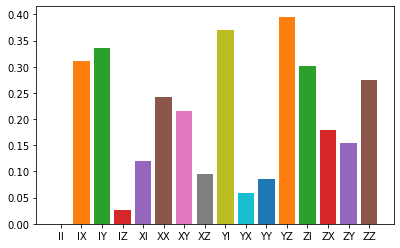

In [7]:

real_errors = {}
transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data
for i,pauli in enumerate(pauli_basis(2, pauli_list = True)):
    real_errors[pauli] = transfer_matrix[i][i]
    plt.bar(pauli.to_label(), 10*(1-transfer_matrix[i][i]).real)

In [8]:
circuits, metadatas = tglp.procedure([2,4,16, 32], 100,100, transpiled=False)

The following pairs require single measurements: [[Pauli('IY'), Pauli('XY')], [Pauli('IX'), Pauli('XX')], [Pauli('ZI'), Pauli('ZZ')], [Pauli('YI'), Pauli('YZ')], [Pauli('YY'), Pauli('ZX')], [Pauli('ZY'), Pauli('YX')]]
Generated 4200 circuits


In [9]:
analysis = ProcedureAnalysis.fromExperiment(tglp)

In [24]:
results = sim.run(circuits, shots=1000, noise_model = noise_model).result().get_counts()

In [25]:
basis_dict = analysis.analyze(results, metadatas)

The following SPAM-free measurements were reconstructed: [('XI', 0.988057666646021), ('IZ', 0.9974302043214438), ('XZ', 0.9906561204754593)]
The following SPAM-free measurement pairs were constructed: [(('IX', 'XX'), 0.9723715678717214), (('XX', 'IX'), 0.9724130161307141), (('YX', 'ZY'), 0.9892160941335149), (('YI', 'YZ'), 0.9618447190912925), (('ZX', 'YY'), 0.9866240539978446), (('ZI', 'ZZ'), 0.9712550828071137), (('XY', 'IY'), 0.9723098180010951), (('IY', 'XY'), 0.9724713057819652), (('YY', 'ZX'), 0.9868386468866381), (('ZY', 'YX'), 0.9894797333564932), (('YZ', 'YI'), 0.961443711841236), (('ZZ', 'ZI'), 0.9712729040597662)]
The following degeneracy-lifting measurements were reconstructed: [('IY', 0.9660113046394535), ('IX', 0.9667960217499826), ('ZI', 0.9703976728480236), ('YI', 0.96473242525285), ('YY', 0.9922684400543441), ('ZY', 0.9851447126733969)]


In [26]:
def nophase(pauli):
    return Pauli((pauli.z, pauli.x))
def display(*paulis):
    fidelities = []
    fidelities_calculated = []
    ax = np.arange(len(tglp.model_paulis))
    for p in tglp.model_paulis:
        fid = basis_dict[p]['fidelity']
        if(basis_dict[p]['type'] == 'pair'):
            pair = nophase(p.evolve(layer))
            fid = fid**2/basis_dict[pair]['fidelity']
        fidelities.append(fid)
        fidelities_calculated.append(real_errors[p])
    plt.bar(ax+.2, [10*(1-f) for f in fidelities], .4,color='b')
    plt.bar(ax-.2, [10*(1-f) for f in fidelities_calculated],.4, color='r')
    plt.xticks(ax, tglp.model_paulis)
    plt.title("Measured vs. ideal fidelities for a CNOT gate")
    plt.xlabel("Pauli term")
    plt.ylabel("10x(1-f)")
    plt.legend(["Measured", "Calculated"])

/home/ben/.local/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


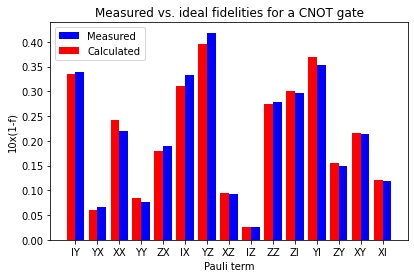

In [27]:
display(*tglp.model_paulis)

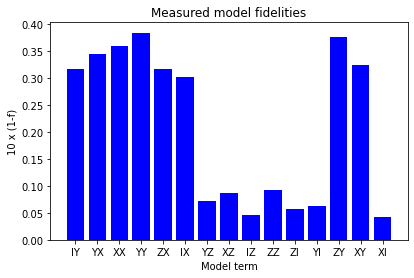

In [14]:
analysis.display(*tglp.model_paulis)

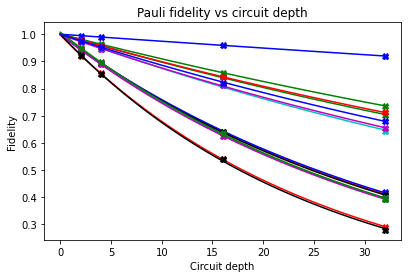

In [23]:
analysis.graph(*tglp.model_paulis)

Model reconstructed with r-norm 0.0020301263260792037


Text(0, 0.5, 'Coefficient')

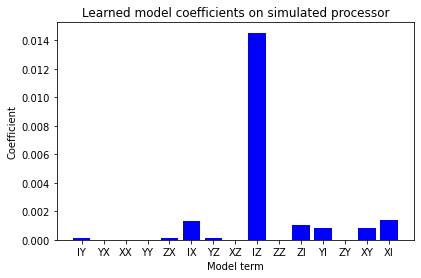

In [16]:
for coeff,term in analysis.fit_model():
        plt.bar(term.to_label(), coeff, color='b')
plt.title("Learned model coefficients on simulated processor")
plt.xlabel("Model term")
plt.ylabel("Coefficient")
